In [12]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
%matplotlib inline

cudnn.benchmark = True

### Create Classification Dataset

In [70]:
def pad_image(img, target_size):
    
    # Calculate padding dimensions
    width, height = img.size
    target_width, target_height = target_size
    pad_width = max(target_width - width, 0)
    pad_height = max(target_height - height, 0)

    # Calculate padding
    left_pad = pad_width // 2
    right_pad = pad_width - left_pad
    top_pad = pad_height // 2
    bottom_pad = pad_height - top_pad

    # Apply padding
    padded_img = Image.new(img.mode, target_size, (255, 255, 255))  # Create a white canvas
    padded_img.paste(img, (left_pad, top_pad))

    return padded_img

In [73]:
import os
import cv2

input_dir = r"component_images"
output_dir = "classification_images"

for folder_name in os.listdir(input_dir):

    os.makedirs(output_dir+f"/{folder_name}", exist_ok=True)

    for file_name in os.listdir(os.path.join(input_dir,folder_name)):

        img = cv2.imread(os.path.join(input_dir, folder_name, file_name))

        #wide and tall
        if img.shape[0] >= 244 and img.shape[1] >= 244: 
            upper_left = img[0:80, 0:120]
            lower_left = img[(img.shape[0]-80):img.shape[0],     0:120]
            upper_right = img[0:80, (img.shape[1]-120):img.shape[1]]
            lower_right = img[img.shape[0]-80:img.shape[0], img.shape[1]-120:img.shape[1]]
            center = img[img.shape[0]//2-40:img.shape[0]//2+40, img.shape[1]//2-120:img.shape[1]//2+120]
            upper_combined = np.concatenate((upper_left, upper_right), axis=1)
            lower_combined = np.concatenate((lower_left, lower_right), axis=1)
            combined_parts = np.concatenate((upper_combined, center, lower_combined), axis=0)
            img = Image.fromarray(combined_parts)

        elif (80 <= img.shape[0] < 244) and img.shape[1] >= 244: 
            upper_left = img[0:80, 0:120]
            lower_left = img[(img.shape[0]-80):img.shape[0], 0:120]
            upper_right = img[0:80, (img.shape[1]-120):img.shape[1]]
            lower_right = img[img.shape[0]-80:img.shape[0], img.shape[1]-120:img.shape[1]]
            # center = img[img.shape[0]//2-40:img.shape[0]//2+40, img.shape[1]//2-120:img.shape[1]//2+120]
            upper_combined = np.concatenate((upper_left, upper_right), axis=1)
            lower_combined = np.concatenate((lower_left, lower_right), axis=1)
            combined_parts = np.concatenate((upper_combined, lower_combined), axis=0)
            img = Image.fromarray(combined_parts)

        elif img.shape[0] <= 80 and img.shape[1] >= 488:
            left = img[0:80, 0:244]
            right = img[0:80, img.shape[1]-244:img.shape[1]]
            center = img[0:80, img.shape[1]//2-122:img.shape[1]//2+122]
            combined_parts = np.concatenate((left, center, right), axis=0)
            img = Image.fromarray(combined_parts)
        elif img.shape[0] <= 80 and img.shape[1] >= 244:
            left = img[0:80, 0:244]
            right = img[0:80, img.shape[1]-244:img.shape[1]]
            # center = img[0:img.shape[0], img.shape[1]//2-122:img.shape[1]//2+122]
            combined_parts = np.concatenate((left, right), axis=0)
            img = Image.fromarray(combined_parts)
       
        else:
            img = Image.fromarray(img)
            

        target_size = (244, 244)
        padded_image = pad_image(img, target_size)
        padded_image.save(output_dir+f"/{folder_name}/{file_name}")


In [72]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path to your dataset
dataset_path = 'classification_images'

# List all the class (label) folders in your dataset
class_folders = [os.path.join(dataset_path, d) for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
class_folders

# Create directories for the training and testing sets
train_dir = 'ui_classification_dataset/train'
test_dir = 'ui_classification_dataset/test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List all the class (label) folders in your dataset
class_folders = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# Iterate through each class folder
for class_folder in class_folders:
    # Create class folders in the training and testing directories
    os.makedirs(os.path.join(train_dir, class_folder), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_folder), exist_ok=True)

    # List all the image filenames in the class folder
    image_files = [os.path.join(dataset_path, class_folder, f) for f in os.listdir(os.path.join(dataset_path, class_folder)) if f.endswith('.png')]

    # Split the image filenames into training and testing sets (80% training, 20% testing)
    train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)

    # Copy the training images to the training directory
    for file in train_files:
        shutil.copy(file, os.path.join(train_dir, class_folder, os.path.basename(file)))

    # Copy the testing images to the testing directory
    for file in test_files:
        shutil.copy(file, os.path.join(test_dir, class_folder, os.path.basename(file)))


## Load Data

In [13]:

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomAffine(degrees=(-0.1, 0.1), translate=(0.0, 0.0), scale=(0.95, 1.05)),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

data_dir = 'ui_classification_dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



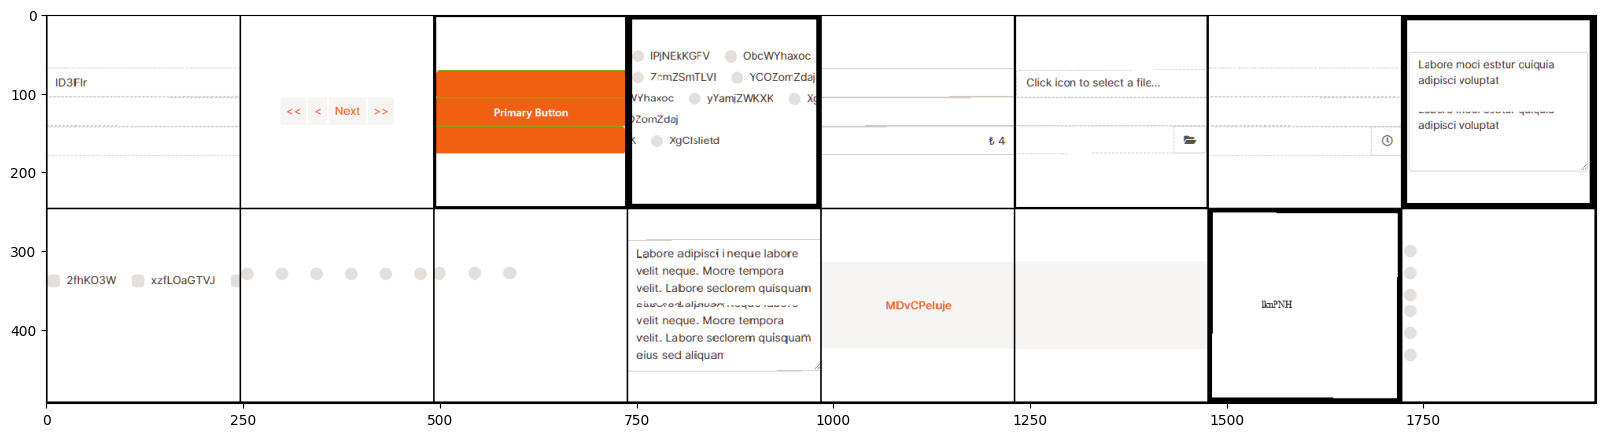

In [14]:
def imshow(inp):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(20,10))
    plt.imshow(inp)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

## Training the model


In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Visualizing the model predictions



In [47]:

def visualize_outputs(model,  num_images=6):
   
    # Model inference
    with torch.no_grad():
        inputs, labels = next(iter(dataloaders['val']))  # Get a batch from the validation dataloader
        inputs = inputs.to(device)
        labels = labels.to(device)

        output_tensor = model(inputs)
        _, preds = torch.max(output_tensor, 1)

        # Plot the first `num_images` images
        fig, axes = plt.subplots(1, num_images, figsize=(18, 6))
        for i in range(num_images):
            ax = axes[i]
            ax.imshow(inputs.cpu().data[i].permute(1, 2, 0))  # Convert to (H, W, C)
            ax.axis('off')
            ax.set_title(f"predicted: {class_names[preds[i]]}")

        plt.tight_layout()
        plt.show()

## Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer.




In [17]:
model_ft = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate

In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.2621 Acc: 0.2752
val Loss: 2.3435 Acc: 0.4553

Epoch 1/24
----------
train Loss: 1.3510 Acc: 0.6020
val Loss: 1.3459 Acc: 0.6342

Epoch 2/24
----------
train Loss: 0.9061 Acc: 0.7228
val Loss: 0.7264 Acc: 0.7685

Epoch 3/24
----------
train Loss: 0.5649 Acc: 0.8347
val Loss: 0.4550 Acc: 0.9008

Epoch 4/24
----------
train Loss: 0.2974 Acc: 0.9257
val Loss: 0.2254 Acc: 0.9591

Epoch 5/24
----------
train Loss: 0.1725 Acc: 0.9564
val Loss: 0.0836 Acc: 0.9864

Epoch 6/24
----------
train Loss: 0.1025 Acc: 0.9777
val Loss: 0.0471 Acc: 0.9942

Epoch 7/24
----------
train Loss: 0.0787 Acc: 0.9832
val Loss: 0.0378 Acc: 0.9942

Epoch 8/24
----------
train Loss: 0.0763 Acc: 0.9832
val Loss: 0.0396 Acc: 0.9922

Epoch 9/24
----------
train Loss: 0.0634 Acc: 0.9886
val Loss: 0.0440 Acc: 0.9883

Epoch 10/24
----------
train Loss: 0.0691 Acc: 0.9876
val Loss: 0.0334 Acc: 0.9942

Epoch 11/24
----------
train Loss: 0.0632 Acc: 0.9886
val Loss: 0.0338 Acc: 0.9961

Ep

C:\Users\yigit\AppData\Local\Temp\ipykernel_25532\3380475524.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


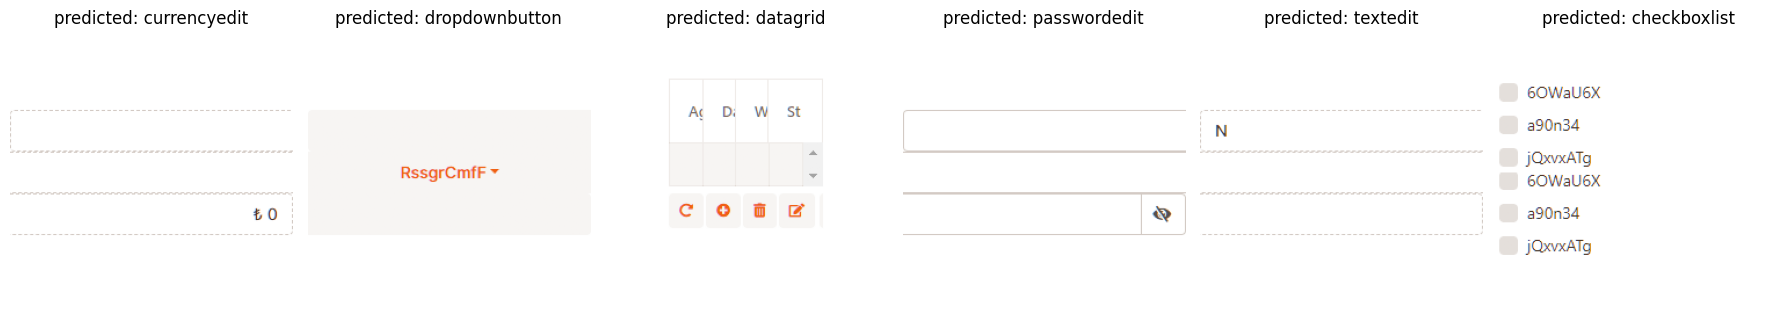

In [53]:
visualize_outputs(model_ft)

In [55]:
# Save the model to a file
torch.save(model_ft.state_dict(), 'cls_model.pth')

In [56]:
model = models.resnet50(pretrained=False).to('cpu')
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 18)  
model = model.to("cpu")
state_dict = torch.load('cls_model.pth',map_location='cpu')
model.load_state_dict(state_dict) 
model.eval()


c:\Users\yigit\Desktop\OpencvUniversity\Pytorch\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yigit\Desktop\OpencvUniversity\Pytorch\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\yigit\AppData\Local\Temp\ipykernel_25532\627840886.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future rel

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Load Model

In [58]:
transform = transforms.Compose([transforms.ToTensor()])

# Load and preprocess the image
image_path = r'ui_classification_dataset\val\maskedit\1_0.png'
image = Image.open(image_path)
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

In [59]:
# Forward pass
with torch.no_grad():
    output = model(input_tensor)

# Get predicted class probabilities
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Get predicted class index
predicted_class = torch.argmax(probabilities).item()

In [61]:
class_names[predicted_class]

'maskedit'